In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

### Data

In [2]:
df = pd.read_csv('movieData.csv')

In [70]:
X = df[['budget_transfer','actor1_count','actor2_count','actor3_count','actor4_count','actor5_count','actor6_count','sequal','year_gap','reunion_holiday','non_reunion_holiday','decade','award_num','company_num','genres_num','directing_win_count','production_companies_freq','genres_freq','director_freq','release_weekday','release_month']]
y = df['revenue_transfer']

### 挑選特徵

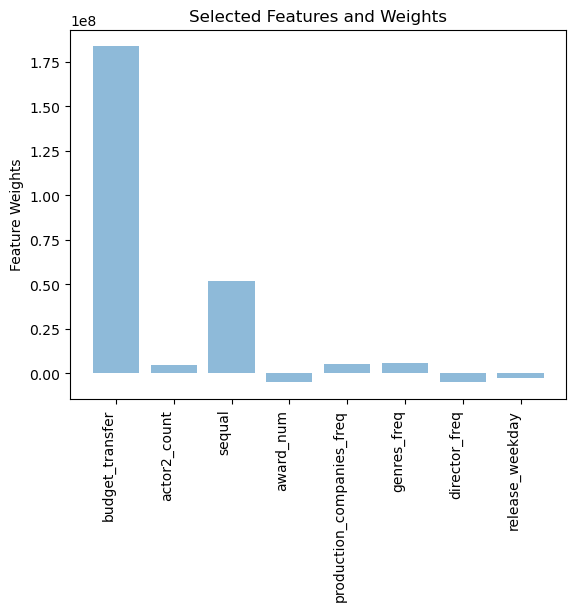

(Index(['budget_transfer', 'actor2_count', 'sequal', 'award_num',
        'production_companies_freq', 'genres_freq', 'director_freq',
        'release_weekday'],
       dtype='object'),
 array([ 1.83635792e+08,  4.78215614e+06,  5.21571667e+07, -4.72660807e+06,
         5.16738062e+06,  5.68190543e+06, -5.05823236e+06, -2.53518767e+06]))

In [13]:
# LASSO

def select_features_with_lasso_and_visualize(X, y, alpha=0.1):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, y)

    nonzero_indices = np.nonzero(lasso.coef_)[0]
    '''np.nonzero(lasso.coef_)獲取 numpy array 中非零元素的索引值  -> (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64),),再取[0],從array取出索引值'''
    
    selected_features = X.columns[nonzero_indices]
    # print(selected_features)
    feature_weights = lasso.coef_[nonzero_indices]

    # Visualize selected features and their weights using a bar chart
    
    # 創建一個繪布與子圖
    fig, ax= plt.subplots()
    y_pos = np.arange(len(selected_features)) # 要幾個長條圖
    
    # align 參數指定條形圖的對齊方式(defual='center')
    # alpha 透明度
    ax.bar(y_pos, feature_weights, align='center', alpha=0.5) 
    
    ax.set_xticks(y_pos)  # 定 x 軸的刻度線位置
    
    # 設定 x 軸刻度線標籤的文字內容
    # 'rotation=90',籤文字會被旋轉 90 度
    # 'ha'指定標籤文字的水平對齊方式(defual = 'center')
    ax.set_xticklabels(selected_features, rotation=90, ha='right') 
    ax.set_ylabel('Feature Weights')
    ax.set_title('Selected Features and Weights')
    plt.show()

    return selected_features, feature_weights
select_features_with_lasso_and_visualize(X, y)

[0.71845652 0.01203922 0.07875578 0.01827676 0.03919176 0.05951952
 0.04438803 0.0293724 ]


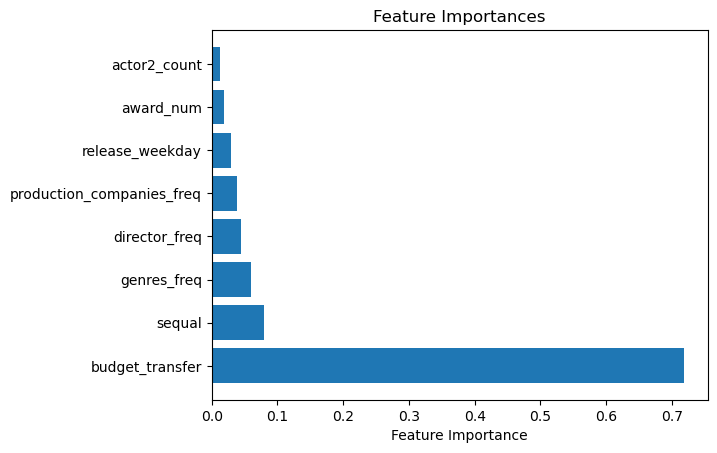

In [14]:
# 隨機森林

def train_rf_and_get_importances_with_plot(X, y, predict_type="regression", top_n=10, threshold=None):
    if predict_type == "classification":
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    rf_model.fit(X, y)
    #  查看每個feature對於模型預測的重要性
    importances = rf_model.feature_importances_ 
    print(importances)
    fig, ax = plt.subplots()
    num_features = len(importances)
    if top_n > num_features:
        top_n = num_features
    
    # np.argsort 返回將輸入陣列排序後的索引位置，默認情況下是遞增排序
    # [-top_n:] 取從倒數第top_n個到最後
    # [::-1] 倒敘呈現 (最大值放第一個)
    indices = np.argsort(importances)[-top_n:][::-1]
    ax.barh(range(top_n), importances[indices], align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([X.columns[i] for i in indices])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Feature Importances')
    plt.show()

    if threshold:
        sfm = SelectFromModel(rf_model, threshold=threshold) # 影響特徵選擇的嚴格程度
        sfm.fit(X, y)
        X_important = sfm.transform(X)
        print(f"篩選後的特徵維度： {X_important.shape[1]}")# 印出特徵
        return X_important # 回傳一個新的數據集 X_important，其中只包含被選擇的特徵。

train_rf_and_get_importances_with_plot(X,y,predict_type="regression")

### 多模型比較

LinearRegression R2 score: 0.6671710888237072
XGBoost R2 score: 0.7035725596857395
DecisionTree R2 score: 0.43018682606674374


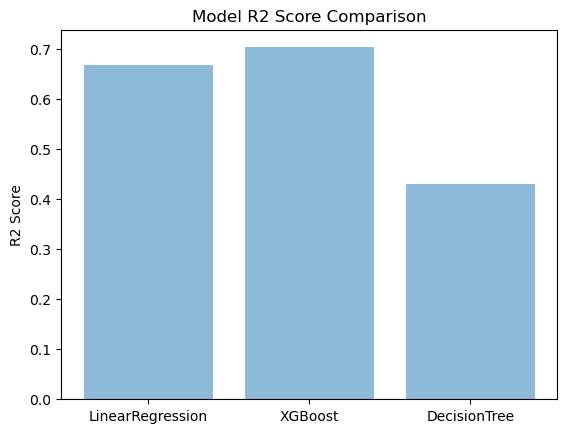

{'LinearRegression': 0.6671710888237072,
 'XGBoost': 0.7035725596857395,
 'DecisionTree': 0.43018682606674374}

In [8]:
def train_and_evaluate_models(X, y, random_state=48, scaler=StandardScaler()):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

    # Standardize data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the models
    models = {
        'LinearRegression': LinearRegression(),
        'XGBoost': xgb.XGBRegressor(max_depth=8, n_estimators=2000, learning_rate=0.008),
        'DecisionTree': DecisionTreeRegressor()
    }

    # Train the models, make predictions and evaluate using R2 score
    r2_scores = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        r2_scores[model_name] = r2_score(y_test, preds)
        print(f'{model_name} R2 score: {r2_scores[model_name]}')

    # Visualize R2 scores using a bar chart
    fig, ax = plt.subplots()
    model_names = list(r2_scores.keys())
    r2_values = list(r2_scores.values())
    y_pos = np.arange(len(model_names))
    ax.bar(y_pos, r2_values, align='center', alpha=0.5)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(model_names)
    ax.set_ylabel('R2 Score')
    ax.set_title('Model R2 Score Comparison')
    plt.show()

    return r2_scores
train_and_evaluate_models(X, y, random_state=1)

### 減少特徵後再次跑模型

budget_transfer              0.788834
actor2_count                 0.106302
sequal                       0.502829
award_num                    0.152859
production_companies_freq   -0.075665
genres_freq                 -0.168374
director_freq                0.185802
release_weekday             -0.203142
target                       1.000000
Name: target, dtype: float64


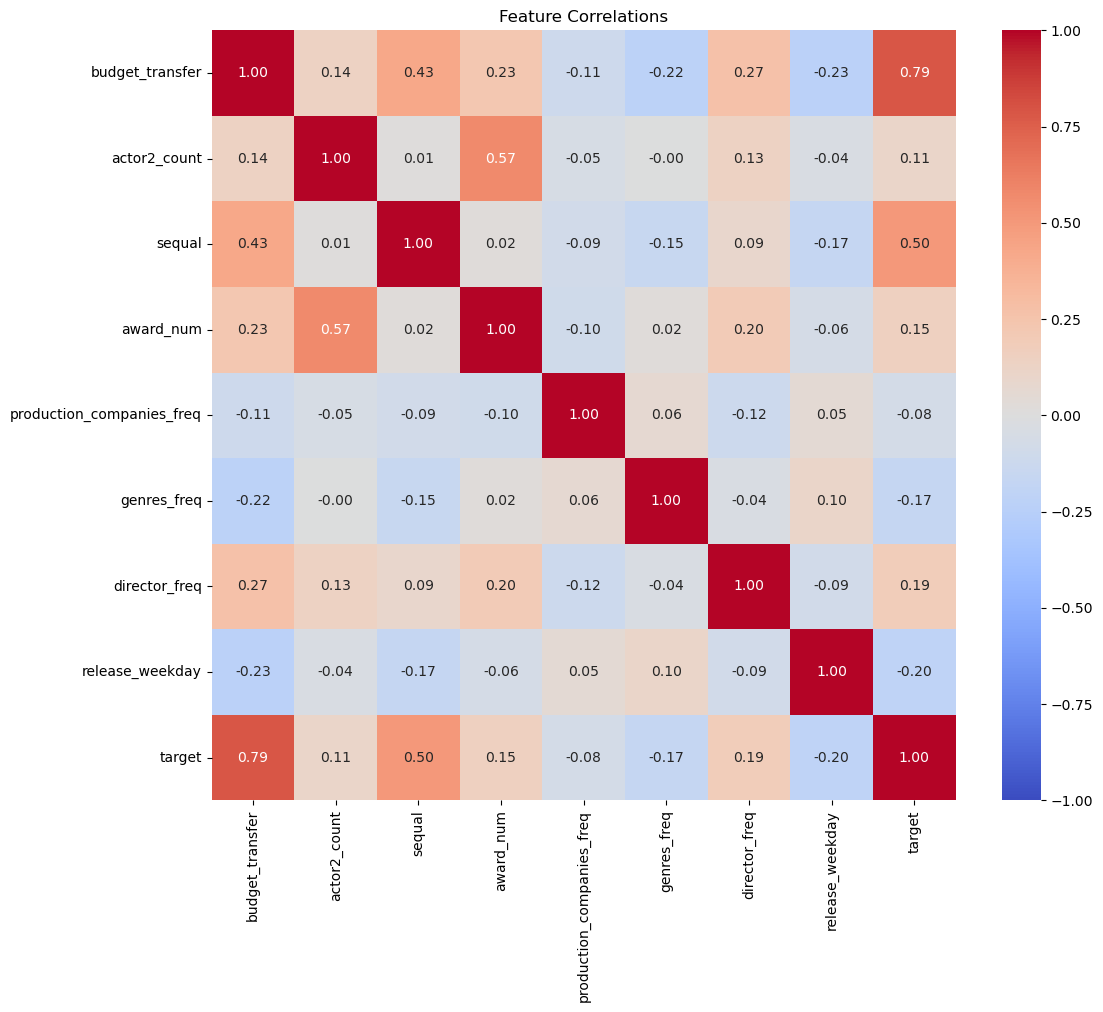

與目標變量的相關係數：
budget_transfer              0.788834
sequal                       0.502829
release_weekday              0.203142
director_freq                0.185802
genres_freq                  0.168374
award_num                    0.152859
actor2_count                 0.106302
production_companies_freq    0.075665
Name: target, dtype: float64

根據相關係數選擇的特徵：
Index(['budget_transfer', 'sequal', 'release_weekday', 'director_freq',
       'genres_freq', 'award_num', 'actor2_count'],
      dtype='object')


Index(['budget_transfer', 'sequal', 'release_weekday', 'director_freq',
       'genres_freq', 'award_num', 'actor2_count'],
      dtype='object')

In [9]:
def select_features_by_correlation(X, y, threshold=0.1, plot_heatmap=True):
    # 將 y 添加到 DataFrame 中
    X_with_target = X.copy()
    X_with_target['target'] = y

    # 計算相關係數的矩陣
    correlations = X_with_target.corr()
    print(correlations['target'])
    # 繪製熱力圖
    if plot_heatmap: # 呈現數據的同時繪製一個顏色地圖
        plt.figure(figsize=(12, 10))
        
        # 'annot' 是否在圖像上標註每個格子中的數值
        # 'cmap' 熱度圖使用的配色方案
        # 'fmt' 標註數值的格式字串
        # 'vmin' 和 'vmax' 熱度圖顏色範圍的最小值和最大值
        sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title("Feature Correlations")
        plt.show()

    # 計算與目標變量的相關係數並排序
    target_correlations = correlations['target'].drop('target', axis=0)
    target_correlations_sorted = target_correlations.abs().sort_values(ascending=False)

    print("與目標變量的相關係數：")
    print(target_correlations_sorted)

    # 挑選與目標變量相關係數絕對值大於某個閾值的特徵
    selected_features = target_correlations_sorted[target_correlations_sorted.abs() > threshold].index
    print("\n根據相關係數選擇的特徵：")
    print(selected_features)

    return selected_features
select_features_by_correlation(X, y)

In [10]:
# 減少特徵欄位
X = df[['budget_transfer','actor2_count','sequal','award_num','production_companies_freq','genres_freq','director_freq','release_weekday',]]
y = df['revenue_transfer']

LinearRegression R2 score: 0.6671710888237072
XGBoost R2 score: 0.7035725596857395
DecisionTree R2 score: 0.4303707349181458


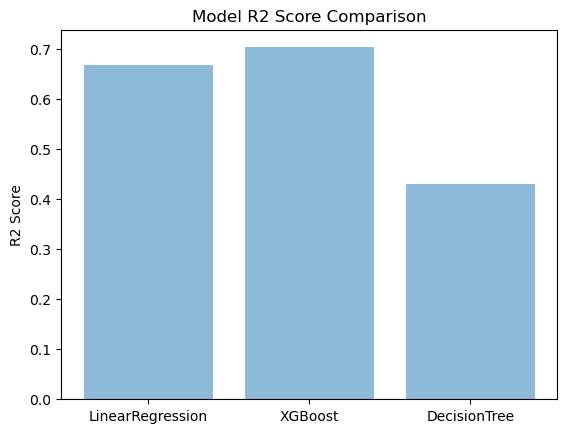

{'LinearRegression': 0.6671710888237072,
 'XGBoost': 0.7035725596857395,
 'DecisionTree': 0.4303707349181458}

In [11]:
train_and_evaluate_models(X, y, random_state=1)

### 選定XGBOOST

[0.71845652 0.01203922 0.07875578 0.01827676 0.03919176 0.05951952
 0.04438803 0.0293724 ]


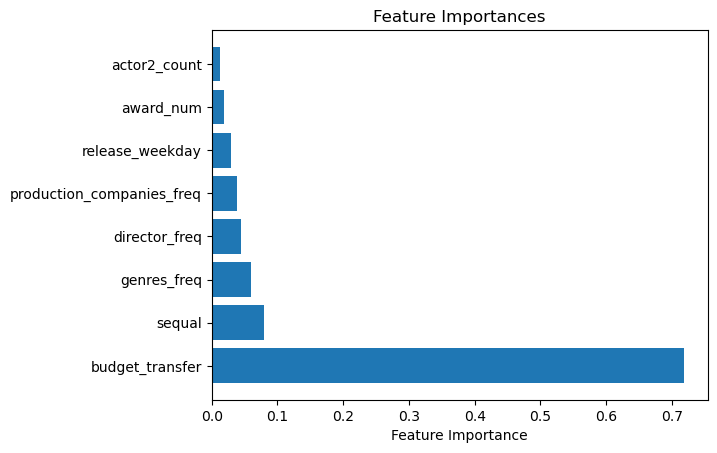

In [15]:
# 隨機森林篩選特徵
train_rf_and_get_importances_with_plot(X,y,predict_type="regression")

In [16]:
# 減少特徵欄位
X = df[['budget_transfer','sequal','award_num','production_companies_freq','genres_freq','director_freq','release_weekday']]
y = df['revenue_transfer']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=48)# 預設test_size=0.25
# 標準化
scaler = StandardScaler()
# 對訓練集進行標準化
X_train = scaler.fit_transform(X_train)
# 對測試集進行標準化
X_test = scaler.transform(X_test)

#將資料分成三份 調整參數
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
# 調整參數，訓練出最好模型
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import xgboost as xgb

# 訓練模型
#'early_stopping_rounds' 早停回合數，如果模型在 n 個迭代中沒有顯著改善，則停止訓練，預設為 None
# 'eval_metric' 模型評估指標，用於衡量模型的效果，預設為 'rmse'
# 'rmse' 均方根誤差 (RMSE, Root Mean Squared Error) 作為模型的評估指標，用於衡量模型預測值與實際值之間的差距
params = {'max_depth': 5, 'n_estimators': 30000, 'learning_rate': 0.0001, 'early_stopping_rounds': 10, 'eval_metric': 'rmse','random_state' :1,}#'booster' :'dart'
xgb_model = xgb.XGBRegressor(**params)


# eval_set=[(X_train, y_train), (X_val, y_val)] 表示在訓練過程中同時對訓練集和驗證集進行評估，進而監控模型的表現
# verbose=0 表示訓練過程中不輸出冗長信息，保持簡潔
# 回傳訓練過程中訓練集和驗證集上 RMSE 值的字典
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)


# 預測結果(用第三份測試集)
y_test_pred = xgb_model.predict(X_test)


# 計算R²
r2_test = r2_score(y_test, y_test_pred)

print(f"R² on testing set: {r2_test:.2f}")


R² on testing set: 0.71


### 將最終訓練的模型存檔 供Flask使用

In [ ]:
# 模型存檔
with open("xgb_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)
# 標準化數據存檔
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)